In [ ]:
import os

import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random

import logging
import time
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#file_path = '/content/drive/MyDrive/boilers_drive/normalized_df.csv'
train_csv_path = '/content/drive/MyDrive/boilers_drive/train_df.csv'
val_csv_path = '/content/drive/MyDrive/boilers_drive/val_df.csv'
test_csv_path = '/content/drive/MyDrive/boilers_drive/test_df.csv'

Mounted at /content/drive


In [ ]:
# Specify the file path of your CSV file

# Read the CSV file
train_data = pd.read_csv(train_csv_path)
val_data = pd.read_csv(val_csv_path)
test_data = pd.read_csv(test_csv_path)

In [ ]:
#print(train_data)
#print(val_data)
#print(test_data)

In [ ]:
# load pre-prepared random order of houses

random_order_houses = pd.read_csv('/content/drive/MyDrive/boilers_drive/random_order_houses.csv')

In [ ]:
# Different houses in data
houses = random_order_houses['house_id'].unique().tolist()
print("Different houses in data:")
print(houses)
print("Number of different houses:")
print(len(houses))

Different houses in data:
['home9', 'home114', 'home5', 'home89', 'home17', 'home63', 'home2', 'home101', 'home14', 'home95', 'home111', 'home67', 'home77', 'home43', 'home86', 'home90', 'home47', 'home110', 'home93', 'home53', 'home34', 'home51', 'home106', 'home46', 'home79', 'home55', 'home65', 'home13']
Number of different houses:
28


In [ ]:
#house_datasets = {}
#for house in houses:
#    house_datasets[house] = data[data['house_id'] == house]

#print(house_datasets)

**Preparing the data**

In [ ]:
# the categories for prediction
final_category = 'blr_mod_lvl'
prediction_categories = ['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out']
normalized_categories = ['normalized_blr_mod_lvl', 'normalized_absorption', 'normalized_insulation', 'normalized_t_r_set', 'normalized_t_out']

In [ ]:
# creating sub-lists, each with the data of one day
# the function that gets category data of a house (ordered by date) and separates by day
def separate_into_days(data_list, minutes_per_day=1440):
    # number of days
    num_days = len(data_list) // minutes_per_day
    # the data into a list of sub-lists, each containing one day's data
    separated_data = [
        data_list[i * minutes_per_day:(i + 1) * minutes_per_day]
        for i in range(num_days)
    ]
    return separated_data


# function to "combine" values of categories and separate into sub-lists based on days
def combine_categories(dataset, categories_list):
    # Combine specified categories into lists
    combined_elements = dataset[categories_list].apply(lambda row: row.tolist(), axis=1)
    return combined_elements.tolist()

In [ ]:
def prepare_data_2(house_data, input_categories, output_category, minutes_per_day=1440):
    combined_input_data = combine_categories(house_data, input_categories)
    separated_input_data = separate_into_days(combined_input_data, minutes_per_day)
    output = house_data[output_category].values
    separated_output = separate_into_days(output, minutes_per_day)
    # [:, :-1] and [:, 1:] for 2-d arrays
    # [:-1],  and [1:] for 1-d arrays (or lists)
    # all except last day are inputs (for prediction)
    input_data = separated_input_data[:-1]
    # all except first day are the corresponding outputs (from prediction)
    output_data = separated_output[1:]
    return input_data, output_data

In [ ]:
# function for getting input and target data
def input_target_split (data, input_categories, num_of_houses):
    filtered_data = data[['house_id', 'time', 'normalized_blr_mod_lvl', 'normalized_absorption', 'normalized_insulation', 'normalized_t_r_set', 'normalized_t_out']].copy()
    input_chosen_categories = []
    for cat in input_categories:
        input_chosen_categories.append('normalized_'+cat)

    # We have 1440 minutes per day
    minutes_per_day = 1440

    # Initialize lists to store input and target pairs
    input_data_list, target_data_list = [], []

    for house_id in houses[:num_of_houses]:
        house_data = filtered_data[filtered_data['house_id'] == house_id]
        house_data = house_data.sort_values(by='time')
        input_data, target_data = prepare_data_2(house_data, input_chosen_categories, 'normalized_blr_mod_lvl')
        input_data_list.append(input_data)
        target_data_list.append(target_data)

    # Combine all houses' data
    input_data = np.concatenate(input_data_list, axis=0)
    target_data = np.concatenate(target_data_list, axis=0)

    return input_data, target_data


In [ ]:
#input_categories = ['blr_mod_lvl']

#num_of_houses = 1
#num_of_houses = 3
#num_of_houses = len(houses)

In [ ]:
def get_split_data(train_data, val_data, test_data, input_categories, num_of_houses):
    input_train, target_train = input_target_split(train_data, input_categories, num_of_houses)
    input_val, target_val = input_target_split(val_data, input_categories, num_of_houses)
    input_test, target_test = input_target_split(test_data, input_categories, num_of_houses)
    return input_train, target_train, input_val, target_val, input_test, target_test

In [ ]:
def get_datasets(input_train, target_train, input_val, target_val, input_test, target_test):
    batch_size = 8 # Reduce the batch size, in case it helps !

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train))
    train_dataset = train_dataset.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((input_val, target_val))
    val_dataset = val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((input_test, target_test))
    test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    # The validation_split argument is designed to work with NumPy arrays or TensorFlow tensors,
    # where it can easily split the data based on a fraction.
    # It doesn't directly work with TensorFlow datasets because they handle data differently.

    return train_dataset, val_dataset, test_dataset

In [ ]:
def print_shapes(input_train, target_train, input_val, target_val, input_test, target_test):
    print(input_train.shape)
    print(target_train.shape)
    print(input_val.shape)
    print(target_val.shape)
    print(input_test.shape)
    print(target_test.shape)
    num_of_categories = input_train.shape[-1]
    print("Number of categories for prediction: "+str(num_of_categories))
    return num_of_categories

In [ ]:
def make_lstm_model(num_of_categories):
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(1440, num_of_categories)))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    # !! 2,3 LSTM and then 2 Dense !!!

    return model

In [ ]:
def train_lstm_model(model, train_dataset, val_dataset):
    # Train the model
    # Define the EarlyStopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Metric to monitor
        patience=10,         # Number of epochs with no improvement after which training will be stopped
        verbose=1,           # Verbosity mode
        restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
    )

    # Train the model with the EarlyStopping callback
    history = model.fit(
        train_dataset,       # Training dataset
        epochs=20,          # Number of epochs
        validation_data=val_dataset,  # Validation dataset
        callbacks=[early_stopping]  # List of callbacks to apply during training
    )
    # change epochs, patience , etc !!! (e.g. epochs=10, patience=3  or  epochs=20, patience=5)

    return model, history

In [ ]:
def training_plots(history):
    # Plotting the training and validation loss and MAE
    plt.figure(figsize=(14, 5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend(loc='upper right')

    # Plot training & validation MAE values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
def save_lstm_model(model, history, input_categories, num_of_houses):
    # save the model
    # !!! I need to save the scalers and the input_test, target_test, test_dataset as well !!!
    # !!! Or I need to use the same for all models (save once and use for all) !!!
    categories_used = '_'.join(input_categories)
    houses_used = str(num_of_houses)

    save_path='/content/drive/Othercomputers/My_Laptop/code/models/'
    model_name = 'lstm_'+categories_used+"_houses_"+houses_used

    # save trained model
    model.save(save_path + model_name + '.keras')

    # save history of training
    with open(save_path + model_name + '_history.pkl', 'wb') as f:
      pickle.dump(history.history, f)

In [ ]:
# do it all completely
def lstm_model_complete(train_data, val_data, test_data, input_categories, num_of_houses):
    print("splitting data")
    input_train, target_train, input_val, target_val, input_test, target_test = get_split_data(train_data, val_data, test_data, input_categories, num_of_houses)
    print("getting datasets")
    train_dataset, val_dataset, test_dataset = get_datasets(input_train, target_train, input_val, target_val, input_test, target_test)
    print("printing shapes and getting num_of_categories")
    num_of_categories = print_shapes(input_train, target_train, input_val, target_val, input_test, target_test)
    print("making lstm model")
    model = make_lstm_model(num_of_categories)
    print("training lstm model")
    model, history = train_lstm_model(model, train_dataset, val_dataset)
    print("the training plots")
    training_plots(history)
    print("saving the model and the training history")
    save_lstm_model(model, history, input_categories, num_of_houses)
    print("finished")

In [ ]:
input_categories = [prediction_categories[0]]

num_of_houses = 1
#num_of_houses = 3
#num_of_houses = len(houses)

possible_num_of_houses = [1, 3, len(houses)]

print(input_categories)
print(num_of_houses)
print(possible_num_of_houses)

['blr_mod_lvl']
1
[1, 3, 28]


---NEW LSTM MODEL---
input_categories: ['blr_mod_lvl']
num_of_houses: 1
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(134, 1440, 1)
(134, 1440)
(33, 1440, 1)
(33, 1440)
(42, 1440, 1)
(42, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0029 - mean_absolute_error: 0.0174 - val_loss: 0.0019 - val_mean_absolute_error: 0.0204
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0031 - mean_absolute_error: 0.0203 - val_loss: 0.0019 - val_mean_absolute_error: 0.0157
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0026 - mean_absolute_error: 0.0181 - val_loss: 0.0019 - val_mean_absolute_error: 0.0168
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0025 - mean_absolute_error: 0.0181 - val_loss: 0.0018 - val_mean_absolute_error: 0.0126
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0026 - mean_absolute_error: 0.0156 - val_loss: 0.0019 - val_mean_absolute_error: 0.0116
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0029 - mean_absolute_error: 0.0164 - val_loss: 0.0019 - val_mean_absolute_error: 0.0201
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0027 - mean_absolute_error: 0.0190 - val_loss: 0.0019 - 

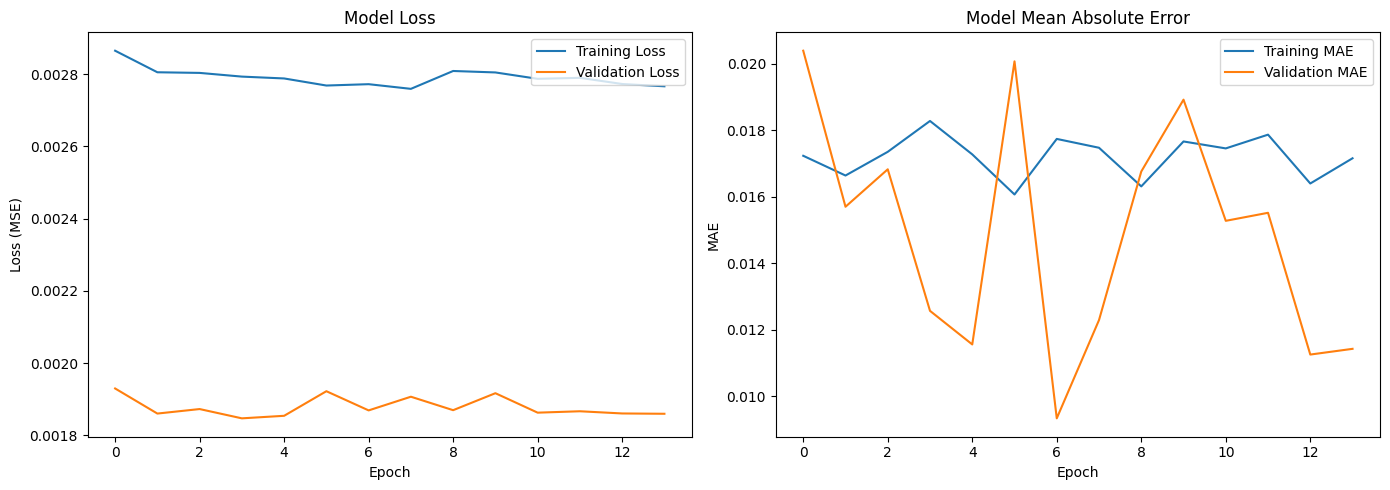

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['blr_mod_lvl']
num_of_houses: 3
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(285, 1440, 1)
(285, 1440)
(71, 1440, 1)
(71, 1440)
(89, 1440, 1)
(89, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0043 - mean_absolute_error: 0.0273 - val_loss: 0.0038 - val_mean_absolute_error: 0.0216
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0035 - mean_absolute_error: 0.0225 - val_loss: 0.0038 - val_mean_absolute_error: 0.0221
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0035 - mean_absolute_error: 0.0241 - val_loss: 0.0038 - val_mean_absolute_error: 0.0239
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0034 - mean_absolute_error: 0.0229 - val_loss: 0.0038 - val_mean_absolute_error: 0.0217
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0036 - mean_absolute_error: 0.0244 - val_loss: 0.0039 - val_mean_absolute_error: 0.0165
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0035 - mean_absolute_error: 0.0208 - val_loss: 0.0038 - val_mean_absolute_error: 0.0240
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0041 - mean_absolute_error: 0.0247 - val_loss: 0.0038 - 

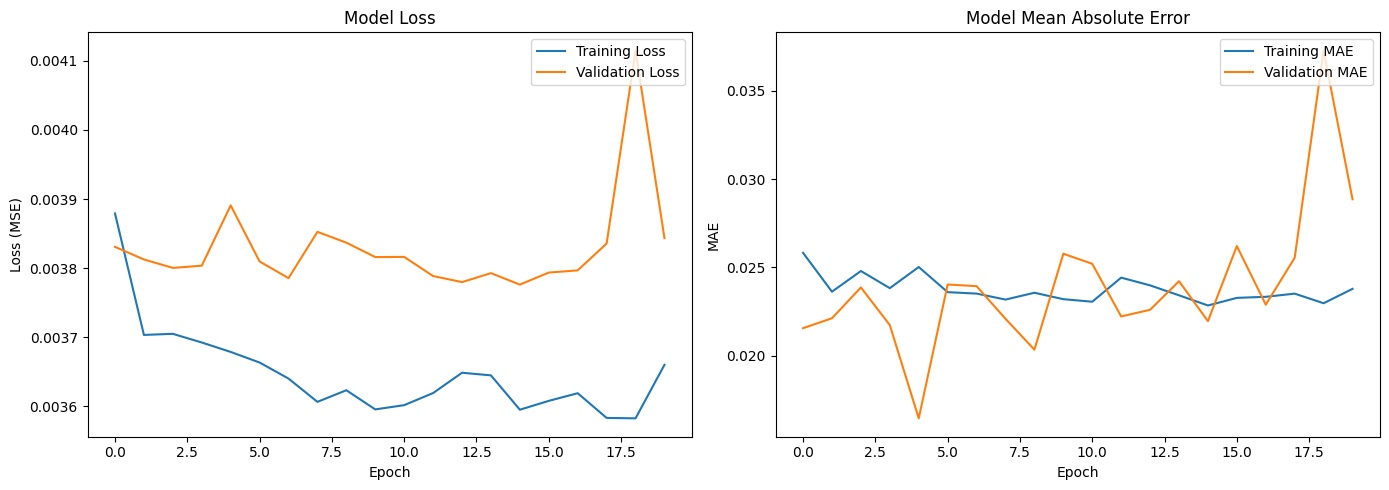

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['blr_mod_lvl']
num_of_houses: 28
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(3338, 1440, 1)
(3338, 1440)
(821, 1440, 1)
(821, 1440)
(1043, 1440, 1)
(1043, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


418/418 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0069 - mean_absolute_error: 0.0380 - val_loss: 0.0072 - val_mean_absolute_error: 0.0435
Epoch 2/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - loss: 0.0072 - mean_absolute_error: 0.0387 - val_loss: 0.0071 - val_mean_absolute_error: 0.0404
Epoch 3/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 0.0069 - mean_absolute_error: 0.0380 - val_loss: 0.0072 - val_mean_absolute_error: 0.0438
Epoch 4/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - loss: 0.0067 - mean_absolute_error: 0.0374 - val_loss: 0.0071 - val_mean_absolute_error: 0.0354
Epoch 5/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - loss: 0.0070 - mean_absolute_error: 0.0386 - val_loss: 0.0072 - val_mean_absolute_error: 0.0406
Epoch 6/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 0.0065 - mean_absolute_error: 0.0364 - val_loss: 0.0072 - val_mean_absolute_error: 0.0436
Epoch 7/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - loss: 0.0068 - mean_absolute_error: 0.0381 

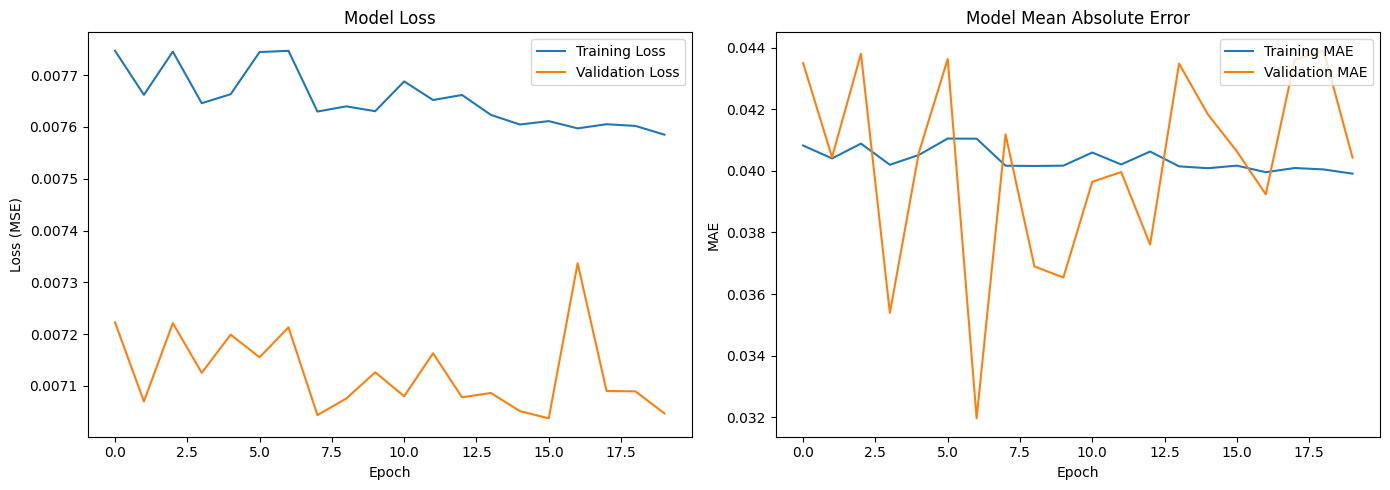

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['absorption']
num_of_houses: 1
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(134, 1440, 1)
(134, 1440)
(33, 1440, 1)
(33, 1440)
(42, 1440, 1)
(42, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0028 - mean_absolute_error: 0.0204 - val_loss: 0.0020 - val_mean_absolute_error: 0.0240
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0031 - mean_absolute_error: 0.0199 - val_loss: 0.0019 - val_mean_absolute_error: 0.0168
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0029 - mean_absolute_error: 0.0184 - val_loss: 0.0018 - val_mean_absolute_error: 0.0132
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0029 - mean_absolute_error: 0.0163 - val_loss: 0.0019 - val_mean_absolute_error: 0.0198
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0030 - mean_absolute_error: 0.0194 - val_loss: 0.0018 - val_mean_absolute_error: 0.0135
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0025 - mean_absolute_error: 0.0157 - val_loss: 0.0018 - val_mean_absolute_error: 0.0134
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0029 - mean_absolute_error: 0.0180 - val_loss: 0.0019 - 

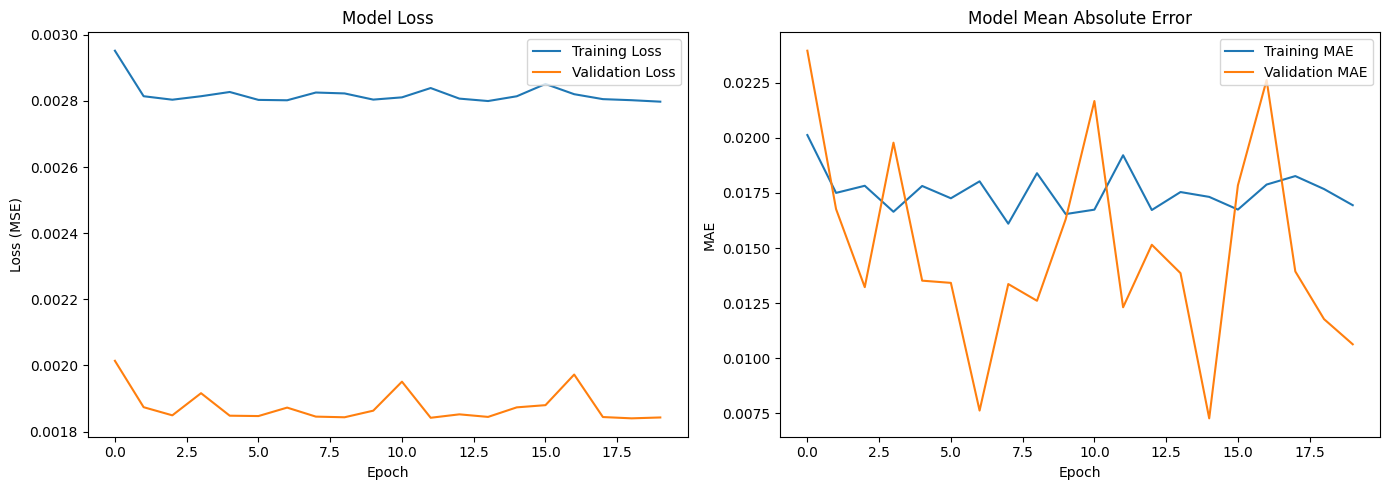

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['absorption']
num_of_houses: 3
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(285, 1440, 1)
(285, 1440)
(71, 1440, 1)
(71, 1440)
(89, 1440, 1)
(89, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0046 - mean_absolute_error: 0.0332 - val_loss: 0.0038 - val_mean_absolute_error: 0.0202
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0038 - mean_absolute_error: 0.0223 - val_loss: 0.0038 - val_mean_absolute_error: 0.0253
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0037 - mean_absolute_error: 0.0251 - val_loss: 0.0038 - val_mean_absolute_error: 0.0276
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0041 - mean_absolute_error: 0.0258 - val_loss: 0.0038 - val_mean_absolute_error: 0.0250
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0036 - mean_absolute_error: 0.0245 - val_loss: 0.0038 - val_mean_absolute_error: 0.0222
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0036 - mean_absolute_error: 0.0251 - val_loss: 0.0038 - val_mean_absolute_error: 0.0226
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0036 - mean_absolute_error: 0.0255 - val_loss: 0.0038 - 

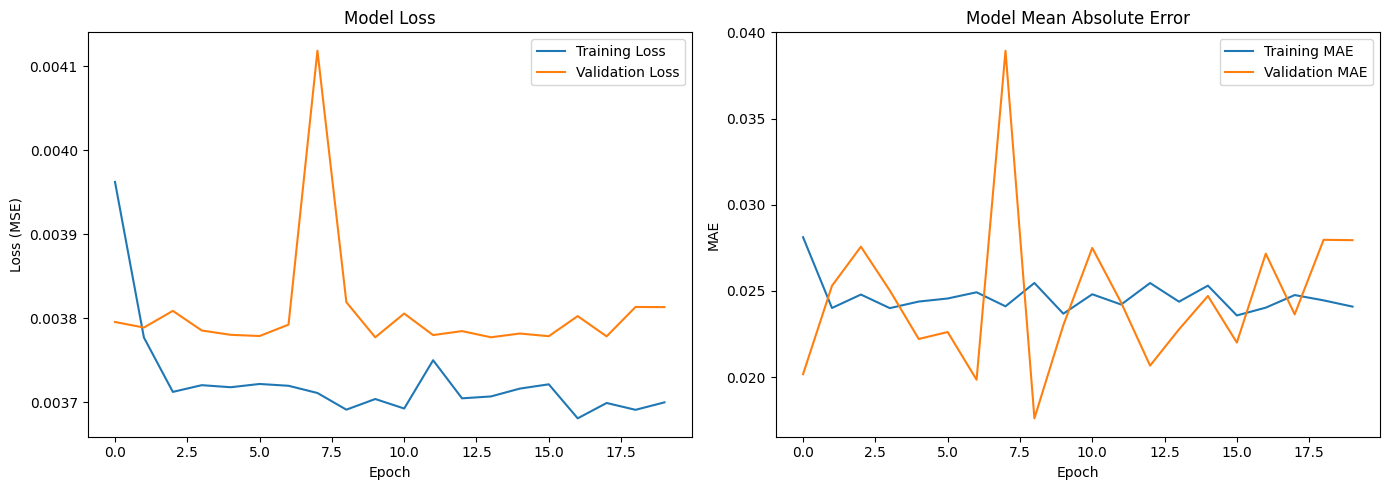

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['absorption']
num_of_houses: 28
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(3338, 1440, 1)
(3338, 1440)
(821, 1440, 1)
(821, 1440)
(1043, 1440, 1)
(1043, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


418/418 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0075 - mean_absolute_error: 0.0415 - val_loss: 0.0072 - val_mean_absolute_error: 0.0401
Epoch 2/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 0.0073 - mean_absolute_error: 0.0405 - val_loss: 0.0072 - val_mean_absolute_error: 0.0417
Epoch 3/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - loss: 0.0072 - mean_absolute_error: 0.0398 - val_loss: 0.0074 - val_mean_absolute_error: 0.0516
Epoch 4/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - loss: 0.0070 - mean_absolute_error: 0.0400 - val_loss: 0.0072 - val_mean_absolute_error: 0.0370
Epoch 5/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 0.0070 - mean_absolute_error: 0.0385 - val_loss: 0.0073 - val_mean_absolute_error: 0.0330
Epoch 6/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 0.0071 - mean_absolute_error: 0.0399 - val_loss: 0.0073 - val_mean_absolute_error: 0.0464
Epoch 7/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 0.0070 - mean_absolute_error: 0.0392 

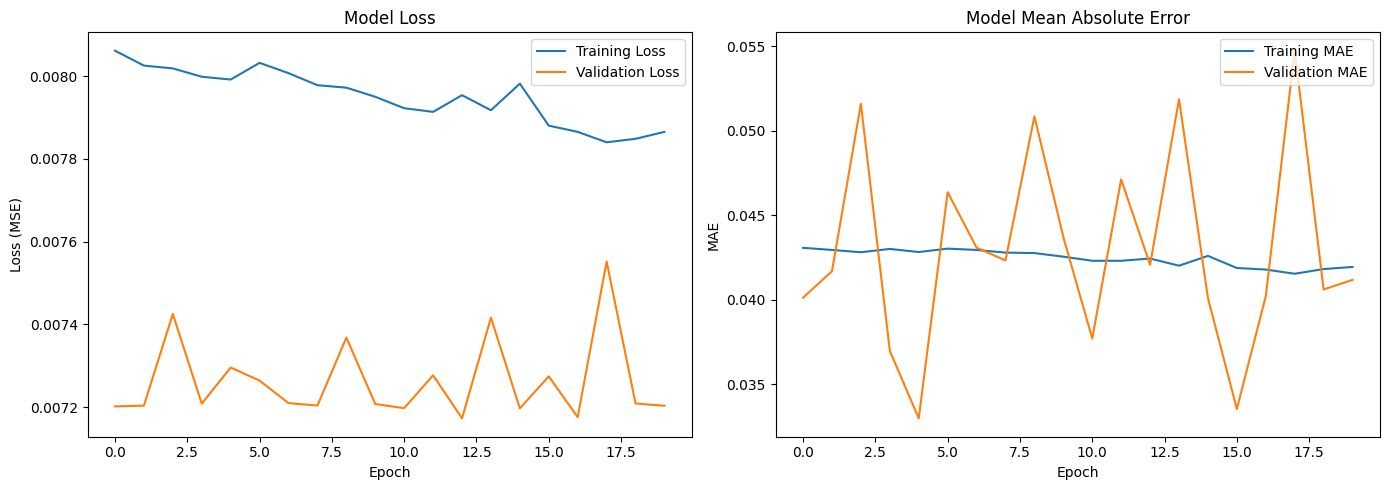

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['insulation']
num_of_houses: 1
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(134, 1440, 1)
(134, 1440)
(33, 1440, 1)
(33, 1440)
(42, 1440, 1)
(42, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0052 - mean_absolute_error: 0.0505 - val_loss: 0.0021 - val_mean_absolute_error: 0.0268
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0029 - mean_absolute_error: 0.0188 - val_loss: 0.0019 - val_mean_absolute_error: 0.0201
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0028 - mean_absolute_error: 0.0179 - val_loss: 0.0019 - val_mean_absolute_error: 0.0196
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0028 - mean_absolute_error: 0.0186 - val_loss: 0.0019 - val_mean_absolute_error: 0.0105
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0029 - mean_absolute_error: 0.0160 - val_loss: 0.0019 - val_mean_absolute_error: 0.0100
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0022 - mean_absolute_error: 0.0137 - val_loss: 0.0019 - val_mean_absolute_error: 0.0142
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0031 - mean_absolute_error: 0.0221 - val_loss: 0.0019 - 

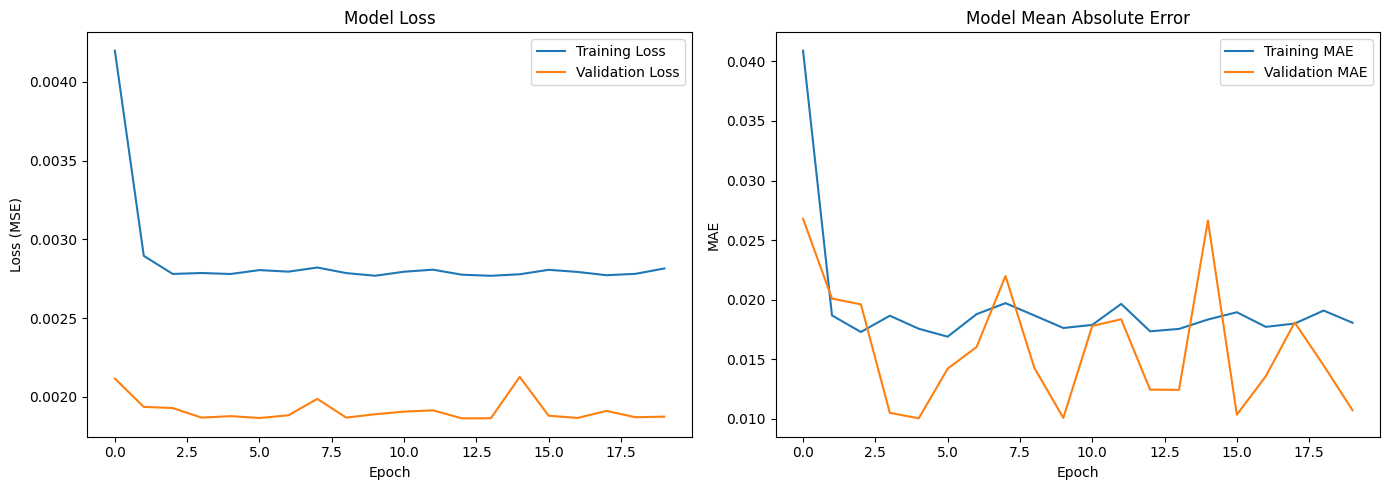

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['insulation']
num_of_houses: 3
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(285, 1440, 1)
(285, 1440)
(71, 1440, 1)
(71, 1440)
(89, 1440, 1)
(89, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0067 - mean_absolute_error: 0.0503 - val_loss: 0.0039 - val_mean_absolute_error: 0.0307
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0034 - mean_absolute_error: 0.0240 - val_loss: 0.0038 - val_mean_absolute_error: 0.0271
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0035 - mean_absolute_error: 0.0245 - val_loss: 0.0038 - val_mean_absolute_error: 0.0223
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0037 - mean_absolute_error: 0.0262 - val_loss: 0.0039 - val_mean_absolute_error: 0.0186
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0037 - mean_absolute_error: 0.0236 - val_loss: 0.0038 - val_mean_absolute_error: 0.0251
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0035 - mean_absolute_error: 0.0230 - val_loss: 0.0039 - val_mean_absolute_error: 0.0289
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0042 - mean_absolute_error: 0.0279 - val_loss: 0.0039 - 

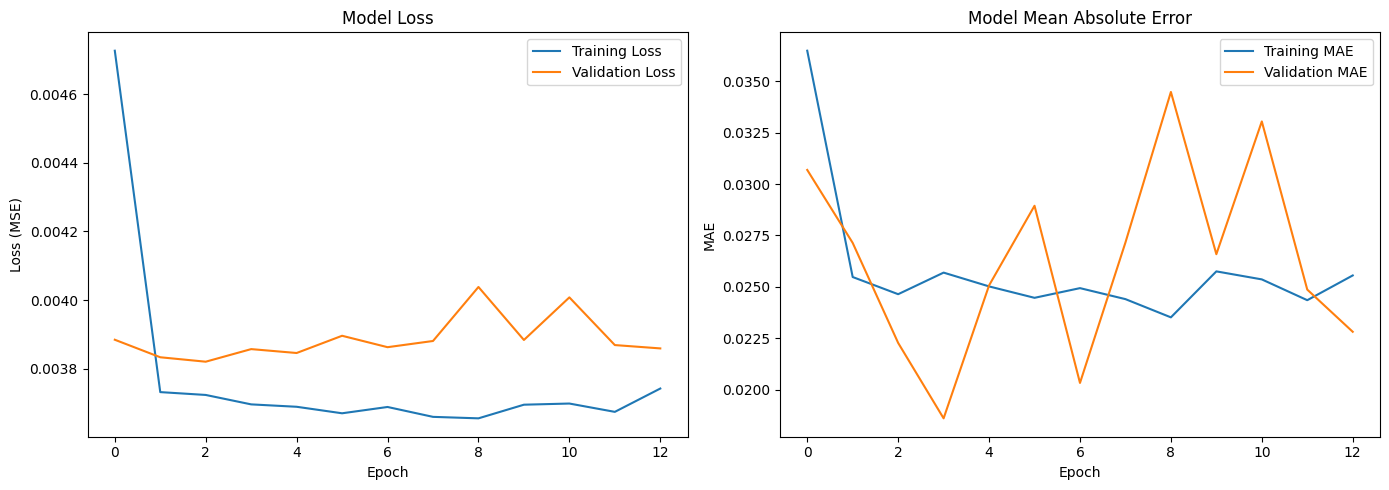

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['insulation']
num_of_houses: 28
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(3338, 1440, 1)
(3338, 1440)
(821, 1440, 1)
(821, 1440)
(1043, 1440, 1)
(1043, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


418/418 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0071 - mean_absolute_error: 0.0398 - val_loss: 0.0074 - val_mean_absolute_error: 0.0489
Epoch 2/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 0.0070 - mean_absolute_error: 0.0394 - val_loss: 0.0073 - val_mean_absolute_error: 0.0463
Epoch 3/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0071 - mean_absolute_error: 0.0393 - val_loss: 0.0073 - val_mean_absolute_error: 0.0454
Epoch 4/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - loss: 0.0068 - mean_absolute_error: 0.0380 - val_loss: 0.0077 - val_mean_absolute_error: 0.0550
Epoch 5/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 0.0068 - mean_absolute_error: 0.0384 - val_loss: 0.0072 - val_mean_absolute_error: 0.0445
Epoch 6/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 0.0068 - mean_absolute_error: 0.0384 - val_loss: 0.0073 - val_mean_absolute_error: 0.0444
Epoch 7/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0072 - mean_absolute_error: 0.0399 

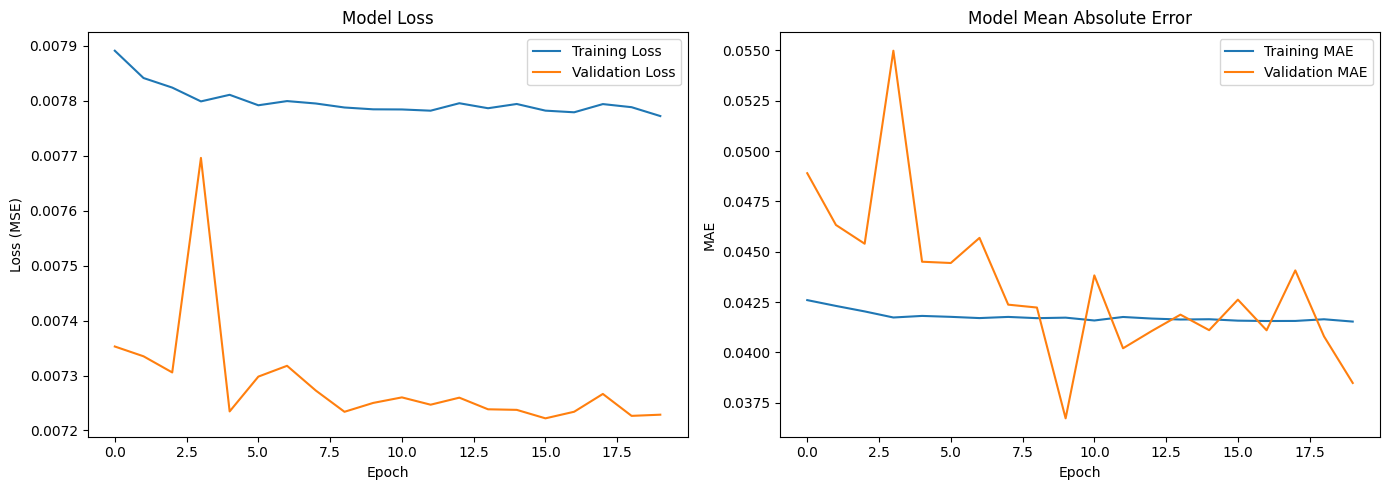

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['t_r_set']
num_of_houses: 1
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(134, 1440, 1)
(134, 1440)
(33, 1440, 1)
(33, 1440)
(42, 1440, 1)
(42, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0050 - mean_absolute_error: 0.0421 - val_loss: 0.0019 - val_mean_absolute_error: 0.0158
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0030 - mean_absolute_error: 0.0237 - val_loss: 0.0019 - val_mean_absolute_error: 0.0116
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0033 - mean_absolute_error: 0.0215 - val_loss: 0.0019 - val_mean_absolute_error: 0.0090
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0028 - mean_absolute_error: 0.0173 - val_loss: 0.0019 - val_mean_absolute_error: 0.0124
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0031 - mean_absolute_error: 0.0197 - val_loss: 0.0019 - val_mean_absolute_error: 0.0183
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0031 - mean_absolute_error: 0.0215 - val_loss: 0.0019 - val_mean_absolute_error: 0.0140
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0027 - mean_absolute_error: 0.0153 - val_loss: 0.0019 - 

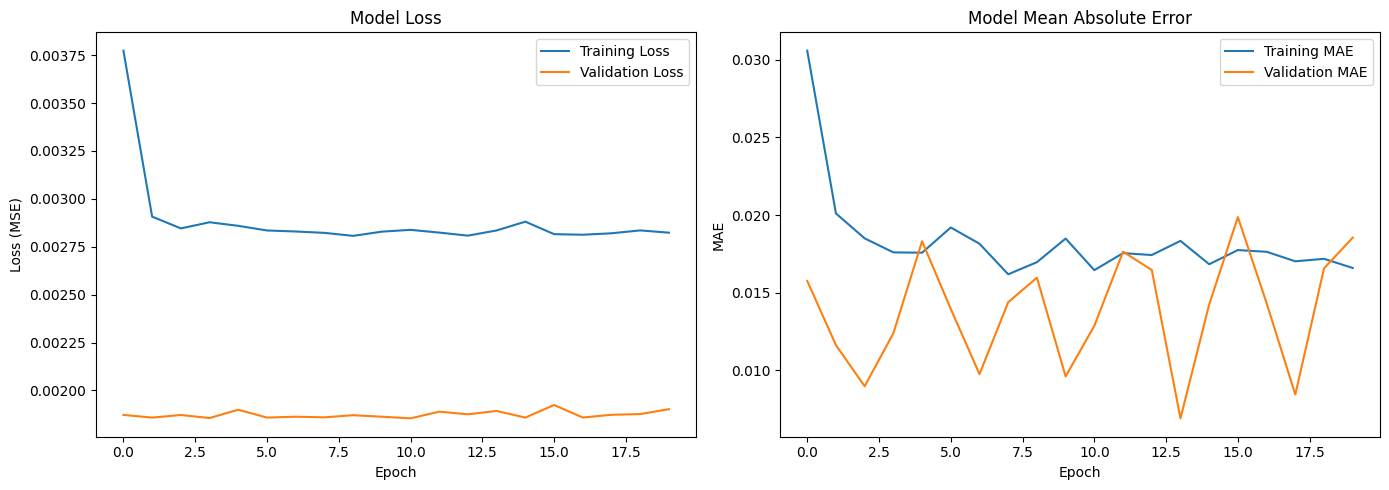

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['t_r_set']
num_of_houses: 3
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(285, 1440, 1)
(285, 1440)
(71, 1440, 1)
(71, 1440)
(89, 1440, 1)
(89, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0038 - mean_absolute_error: 0.0270 - val_loss: 0.0038 - val_mean_absolute_error: 0.0276
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0036 - mean_absolute_error: 0.0237 - val_loss: 0.0039 - val_mean_absolute_error: 0.0171
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0035 - mean_absolute_error: 0.0249 - val_loss: 0.0040 - val_mean_absolute_error: 0.0344
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0041 - mean_absolute_error: 0.0287 - val_loss: 0.0039 - val_mean_absolute_error: 0.0308
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0042 - mean_absolute_error: 0.0290 - val_loss: 0.0038 - val_mean_absolute_error: 0.0185
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0037 - mean_absolute_error: 0.0231 - val_loss: 0.0038 - val_mean_absolute_error: 0.0286
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0040 - mean_absolute_error: 0.0256 - val_loss: 0.0038 - 

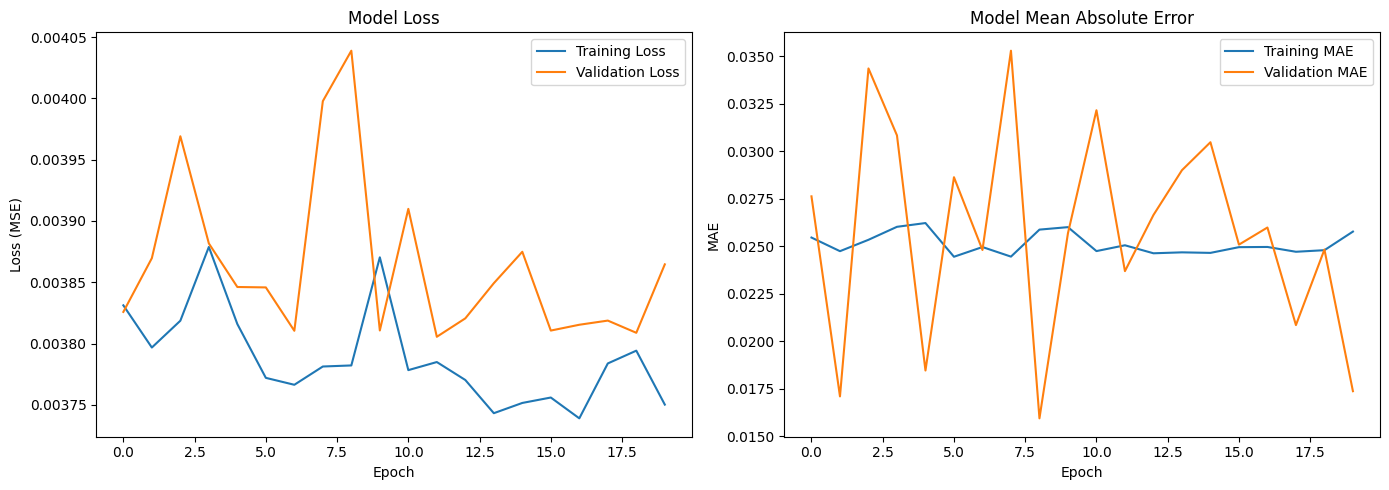

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['t_r_set']
num_of_houses: 28
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(3338, 1440, 1)
(3338, 1440)
(821, 1440, 1)
(821, 1440)
(1043, 1440, 1)
(1043, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


418/418 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 0.0073 - mean_absolute_error: 0.0412 - val_loss: 0.0072 - val_mean_absolute_error: 0.0440
Epoch 2/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0073 - mean_absolute_error: 0.0399 - val_loss: 0.0071 - val_mean_absolute_error: 0.0408
Epoch 3/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.0069 - mean_absolute_error: 0.0384 - val_loss: 0.0072 - val_mean_absolute_error: 0.0453
Epoch 4/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.0073 - mean_absolute_error: 0.0403 - val_loss: 0.0072 - val_mean_absolute_error: 0.0438
Epoch 5/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 0.0069 - mean_absolute_error: 0.0384 - val_loss: 0.0074 - val_mean_absolute_error: 0.0530
Epoch 6/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 0.0073 - mean_absolute_error: 0.0399 - val_loss: 0.0072 - val_mean_absolute_error: 0.0457
Epoch 7/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.0071 - mean_absolute_error: 0.0393 

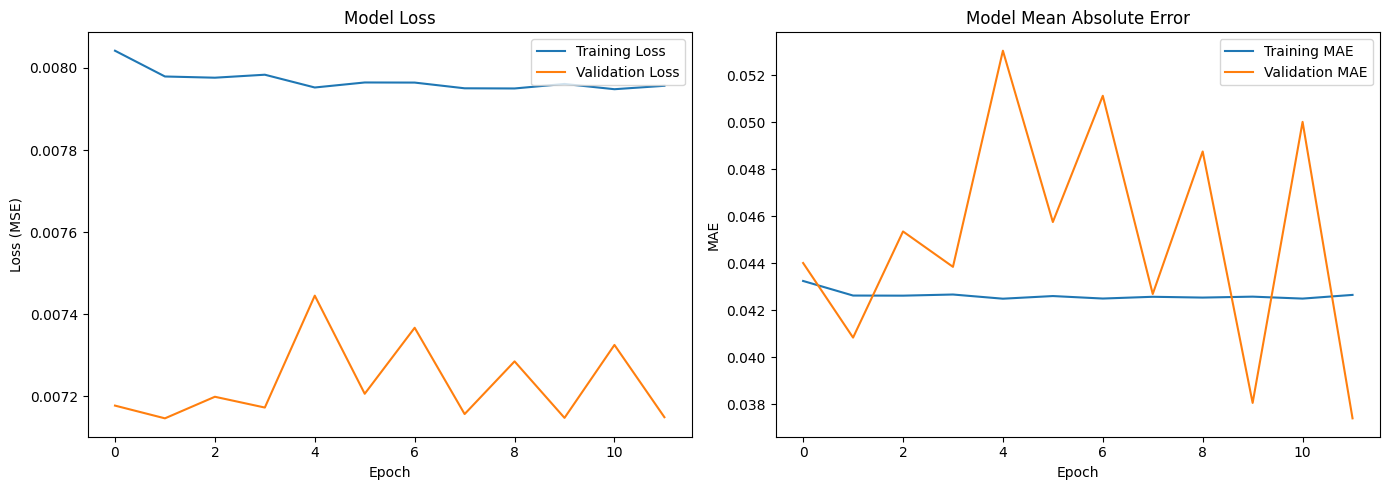

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['t_out']
num_of_houses: 1
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(134, 1440, 1)
(134, 1440)
(33, 1440, 1)
(33, 1440)
(42, 1440, 1)
(42, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0031 - mean_absolute_error: 0.0264 - val_loss: 0.0019 - val_mean_absolute_error: 0.0093
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0028 - mean_absolute_error: 0.0169 - val_loss: 0.0019 - val_mean_absolute_error: 0.0178
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0028 - mean_absolute_error: 0.0193 - val_loss: 0.0019 - val_mean_absolute_error: 0.0193
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0031 - mean_absolute_error: 0.0204 - val_loss: 0.0019 - val_mean_absolute_error: 0.0175
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0025 - mean_absolute_error: 0.0165 - val_loss: 0.0019 - val_mean_absolute_error: 0.0207
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0026 - mean_absolute_error: 0.0179 - val_loss: 0.0019 - val_mean_absolute_error: 0.0165
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0030 - mean_absolute_error: 0.0190 - val_loss: 0.0019 - 

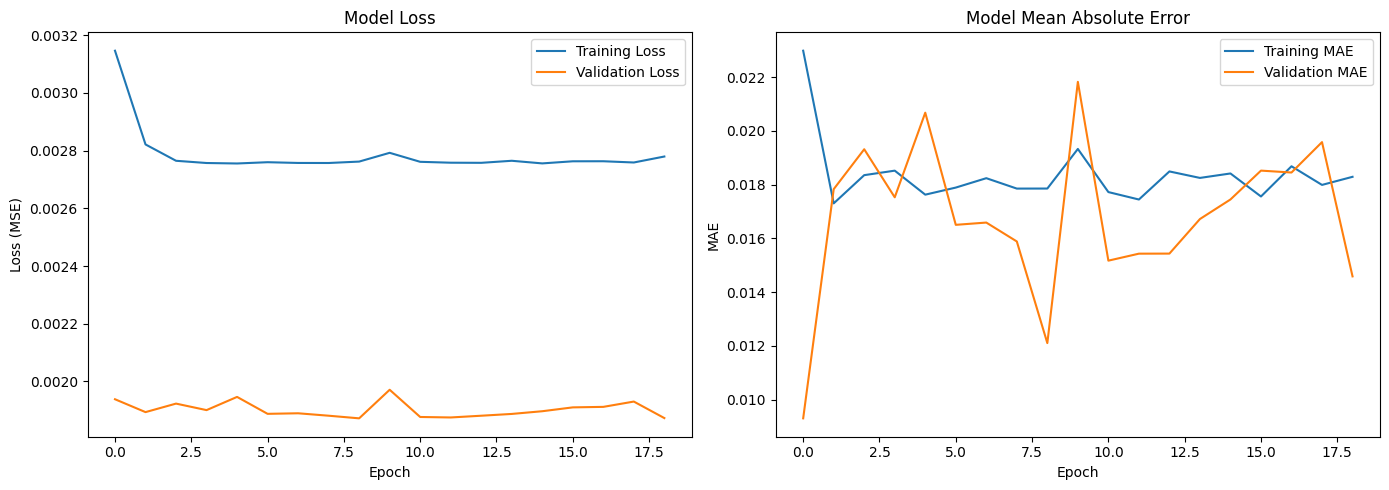

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['t_out']
num_of_houses: 3
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(285, 1440, 1)
(285, 1440)
(71, 1440, 1)
(71, 1440)
(89, 1440, 1)
(89, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0039 - mean_absolute_error: 0.0292 - val_loss: 0.0038 - val_mean_absolute_error: 0.0256
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0034 - mean_absolute_error: 0.0237 - val_loss: 0.0039 - val_mean_absolute_error: 0.0262
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0035 - mean_absolute_error: 0.0240 - val_loss: 0.0040 - val_mean_absolute_error: 0.0324
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0035 - mean_absolute_error: 0.0253 - val_loss: 0.0039 - val_mean_absolute_error: 0.0274
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0039 - mean_absolute_error: 0.0262 - val_loss: 0.0039 - val_mean_absolute_error: 0.0276
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0042 - mean_absolute_error: 0.0278 - val_loss: 0.0039 - val_mean_absolute_error: 0.0251
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0040 - mean_absolute_error: 0.0261 - val_loss: 0.0040 - 

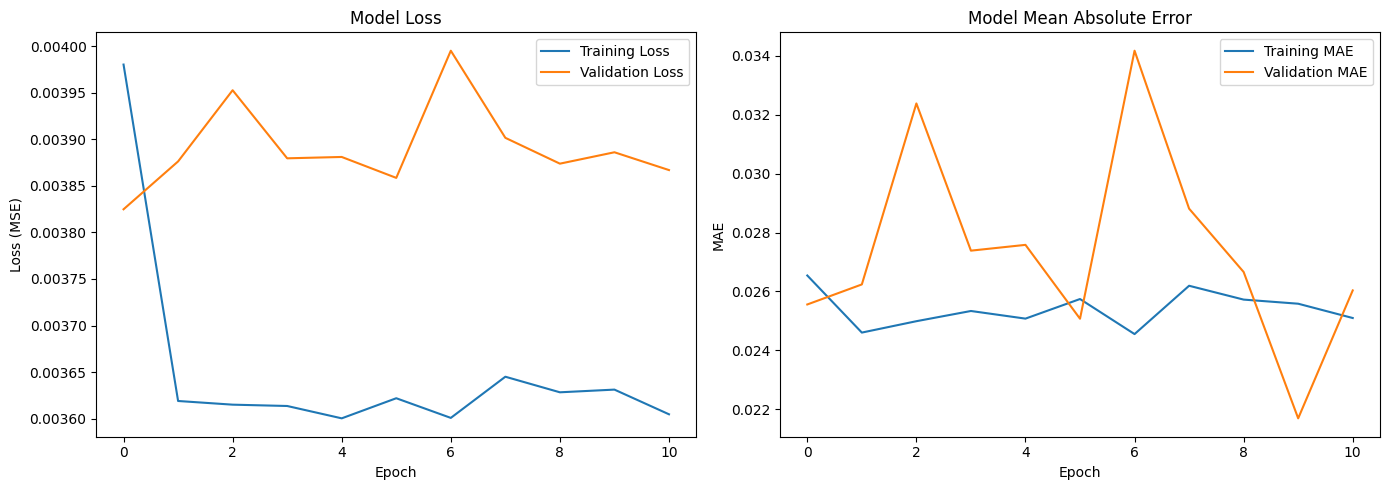

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['t_out']
num_of_houses: 28
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(3338, 1440, 1)
(3338, 1440)
(821, 1440, 1)
(821, 1440)
(1043, 1440, 1)
(1043, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


418/418 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.0071 - mean_absolute_error: 0.0396 - val_loss: 0.0073 - val_mean_absolute_error: 0.0390
Epoch 2/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 0.0069 - mean_absolute_error: 0.0386 - val_loss: 0.0076 - val_mean_absolute_error: 0.0553
Epoch 3/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.0070 - mean_absolute_error: 0.0394 - val_loss: 0.0075 - val_mean_absolute_error: 0.0530
Epoch 4/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.0070 - mean_absolute_error: 0.0397 - val_loss: 0.0073 - val_mean_absolute_error: 0.0422
Epoch 5/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.0071 - mean_absolute_error: 0.0392 - val_loss: 0.0075 - val_mean_absolute_error: 0.0533
Epoch 6/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.0070 - mean_absolute_error: 0.0392 - val_loss: 0.0074 - val_mean_absolute_error: 0.0486
Epoch 7/20
418/418 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.0071 - mean_absolute_error: 0.0392 

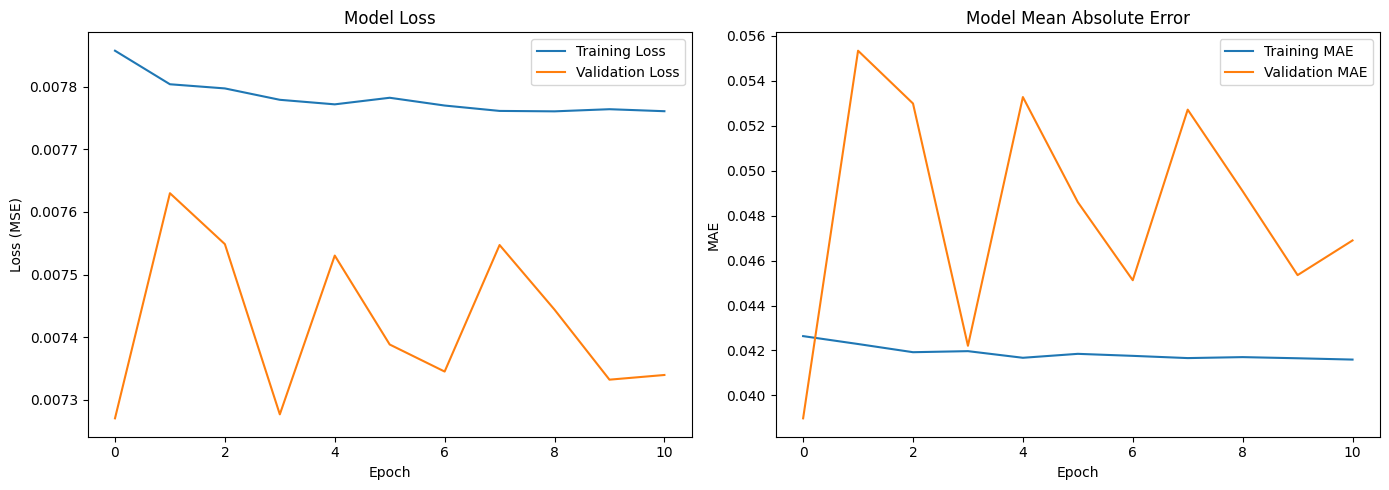

saving the model and the training history
finished
--------------------


In [ ]:
for input_category in prediction_categories:
    input_categories = [input_category]
    for num_of_houses in possible_num_of_houses:
        print("---NEW LSTM MODEL---")
        print("input_categories: "+str(input_categories))
        print("num_of_houses: "+str(num_of_houses))
        print("--------------------")
        lstm_model_complete(train_data, val_data, test_data, input_categories, num_of_houses)
        print("--------------------")

---NEW LSTM MODEL---
input_categories: ['blr_mod_lvl']
num_of_houses: 10
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(1154, 1440, 1)
(1154, 1440)
(285, 1440, 1)
(285, 1440)
(360, 1440, 1)
(360, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0067 - mean_absolute_error: 0.0363 - val_loss: 0.0054 - val_mean_absolute_error: 0.0391
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0063 - mean_absolute_error: 0.0357 - val_loss: 0.0055 - val_mean_absolute_error: 0.0303
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0059 - mean_absolute_error: 0.0346 - val_loss: 0.0053 - val_mean_absolute_error: 0.0350
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0059 - mean_absolute_error: 0.0337 - val_loss: 0.0053 - val_mean_absolute_error: 0.0332
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0059 - mean_absolute_error: 0.0339 - val_loss: 0.0053 - val_mean_absolute_error: 0.0316
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0066 - mean_absolute_error: 0.0360 - val_loss: 0.0053 - val_mean_absolute_error: 0.0320
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0062 - mean_absolute_error: 0.0350 - va

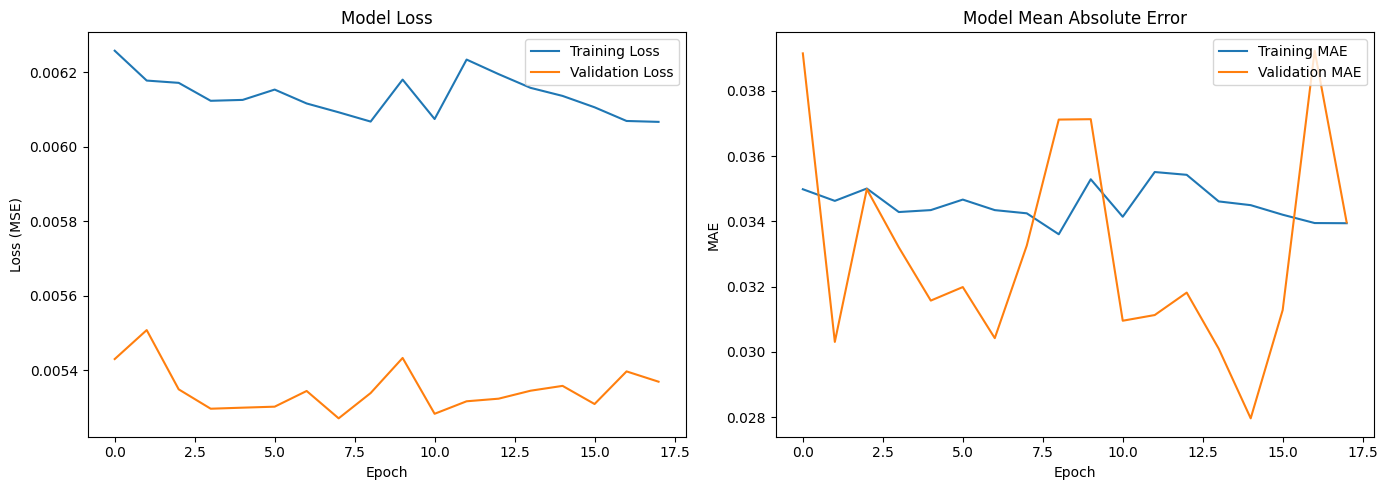

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['absorption']
num_of_houses: 10
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(1154, 1440, 1)
(1154, 1440)
(285, 1440, 1)
(285, 1440)
(360, 1440, 1)
(360, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0066 - mean_absolute_error: 0.0399 - val_loss: 0.0053 - val_mean_absolute_error: 0.0354
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0060 - mean_absolute_error: 0.0349 - val_loss: 0.0054 - val_mean_absolute_error: 0.0407
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0056 - mean_absolute_error: 0.0332 - val_loss: 0.0053 - val_mean_absolute_error: 0.0336
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0067 - mean_absolute_error: 0.0388 - val_loss: 0.0053 - val_mean_absolute_error: 0.0349
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0062 - mean_absolute_error: 0.0362 - val_loss: 0.0054 - val_mean_absolute_error: 0.0334
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0059 - mean_absolute_error: 0.0342 - val_loss: 0.0053 - val_mean_absolute_error: 0.0335
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0062 - mean_absolute_error: 0.0350 - val_

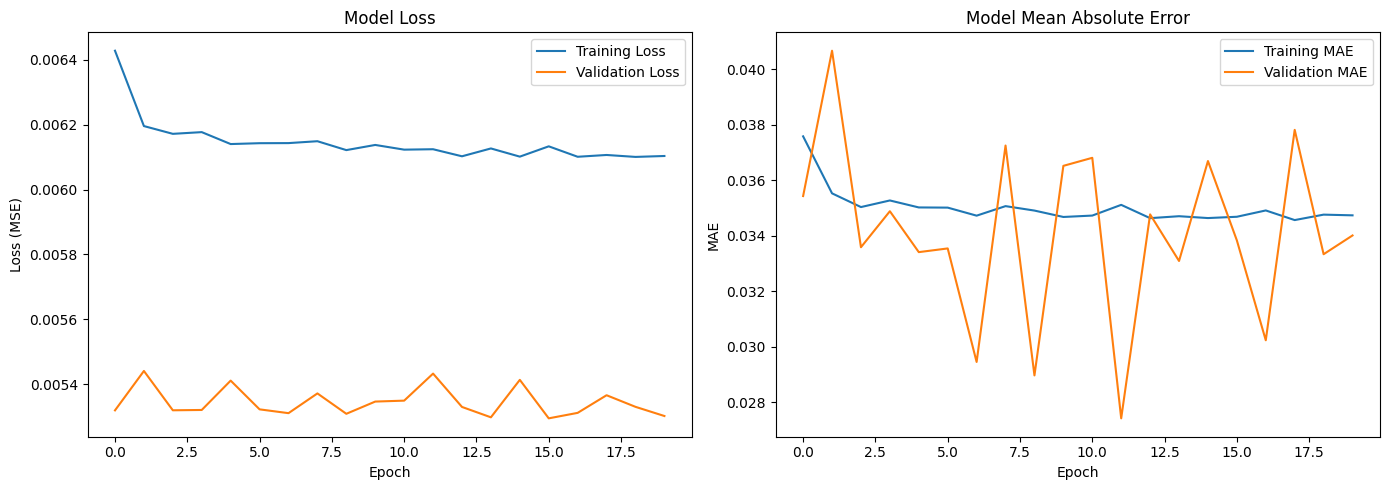

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['insulation']
num_of_houses: 10
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(1154, 1440, 1)
(1154, 1440)
(285, 1440, 1)
(285, 1440)
(360, 1440, 1)
(360, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0065 - mean_absolute_error: 0.0396 - val_loss: 0.0054 - val_mean_absolute_error: 0.0380
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0062 - mean_absolute_error: 0.0358 - val_loss: 0.0054 - val_mean_absolute_error: 0.0264
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.0061 - mean_absolute_error: 0.0354 - val_loss: 0.0054 - val_mean_absolute_error: 0.0371
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0066 - mean_absolute_error: 0.0373 - val_loss: 0.0054 - val_mean_absolute_error: 0.0378
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0063 - mean_absolute_error: 0.0357 - val_loss: 0.0054 - val_mean_absolute_error: 0.0280
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0063 - mean_absolute_error: 0.0345 - val_loss: 0.0054 - val_mean_absolute_error: 0.0375
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0062 - mean_absolute_error: 0.0352 - va

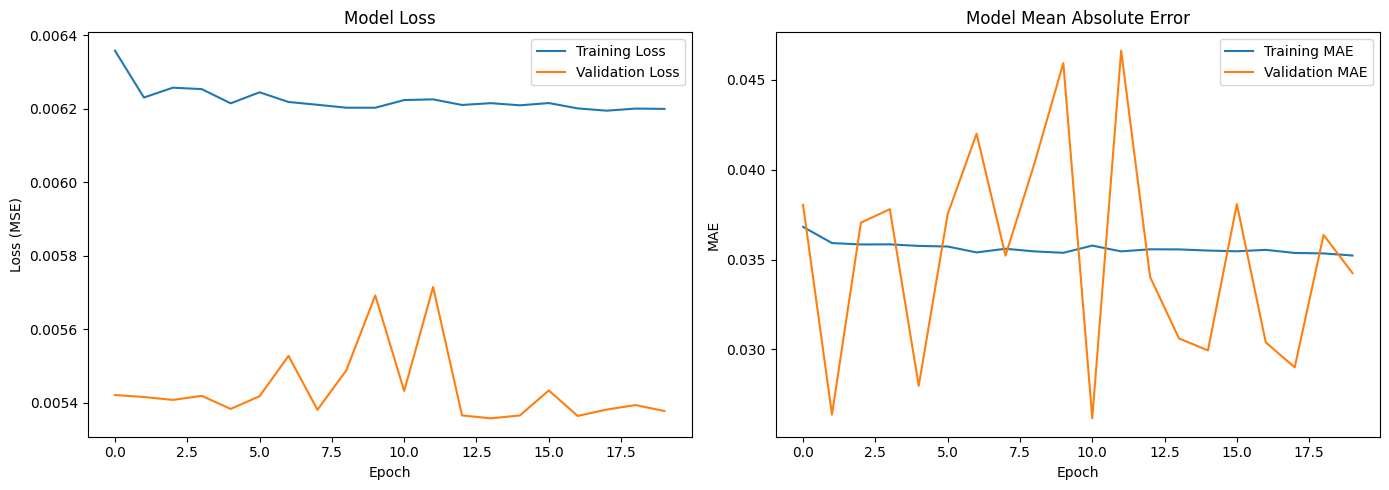

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['t_r_set']
num_of_houses: 10
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(1154, 1440, 1)
(1154, 1440)
(285, 1440, 1)
(285, 1440)
(360, 1440, 1)
(360, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0069 - mean_absolute_error: 0.0398 - val_loss: 0.0054 - val_mean_absolute_error: 0.0369
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0064 - mean_absolute_error: 0.0360 - val_loss: 0.0055 - val_mean_absolute_error: 0.0240
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0063 - mean_absolute_error: 0.0353 - val_loss: 0.0054 - val_mean_absolute_error: 0.0385
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0063 - mean_absolute_error: 0.0358 - val_loss: 0.0054 - val_mean_absolute_error: 0.0369
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0069 - mean_absolute_error: 0.0370 - val_loss: 0.0053 - val_mean_absolute_error: 0.0326
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.0063 - mean_absolute_error: 0.0360 - val_loss: 0.0054 - val_mean_absolute_error: 0.0267
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0071 - mean_absolute_error: 0.0379 - v

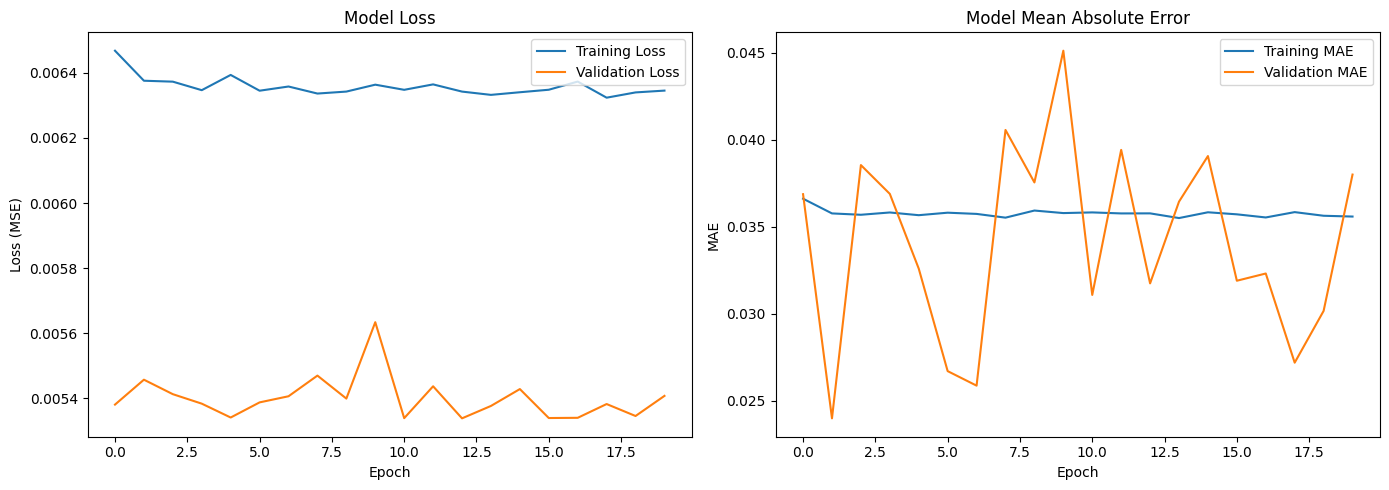

saving the model and the training history
finished
--------------------
---NEW LSTM MODEL---
input_categories: ['t_out']
num_of_houses: 10
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(1154, 1440, 1)
(1154, 1440)
(285, 1440, 1)
(285, 1440)
(360, 1440, 1)
(360, 1440)
Number of categories for prediction: 1
making lstm model
training lstm model
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0069 - mean_absolute_error: 0.0424 - val_loss: 0.0054 - val_mean_absolute_error: 0.0343
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0057 - mean_absolute_error: 0.0342 - val_loss: 0.0054 - val_mean_absolute_error: 0.0338
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0060 - mean_absolute_error: 0.0349 - val_loss: 0.0054 - val_mean_absolute_error: 0.0387
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0064 - mean_absolute_error: 0.0365 - val_loss: 0.0056 - val_mean_absolute_error: 0.0437
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0063 - mean_absolute_error: 0.0365 - val_loss: 0.0055 - val_mean_absolute_error: 0.0394
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0059 - mean_absolute_error: 0.0348 - val_loss: 0.0056 - val_mean_absolute_error: 0.0431
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0062 - mean_absolute_error: 0.0375 - val

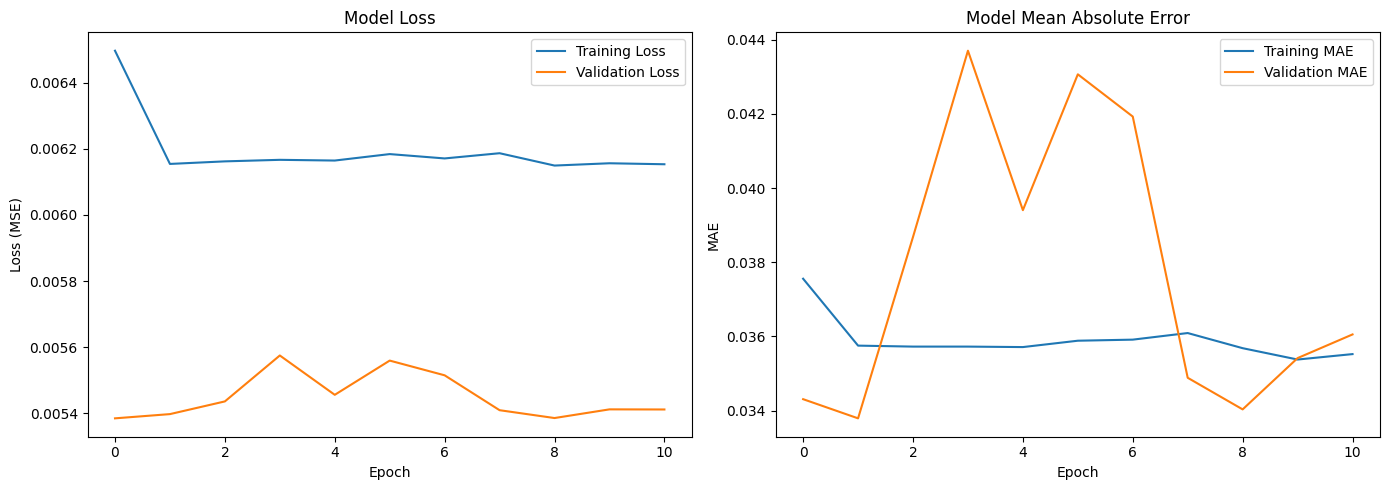

saving the model and the training history
finished
--------------------


In [ ]:
for input_category in prediction_categories:
    input_categories = [input_category]
    for num_of_houses in [10]:
        print("---NEW LSTM MODEL---")
        print("input_categories: "+str(input_categories))
        print("num_of_houses: "+str(num_of_houses))
        print("--------------------")
        lstm_model_complete(train_data, val_data, test_data, input_categories, num_of_houses)
        print("--------------------")